In [409]:
import tensorflow as tf
from tensorflow import keras
import EscapeNet2Executer as Esc
 #binding data save
import escape 
from escape import read_wildSequence

# embd_weights= model.get_layer('embedding').get_weights()[0]
import pandas as pd
from BiLSTMLanguageModeler import BiLSTMLanguageModel
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#plotting 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 


In [410]:
feature_model = keras.models.load_model('/home/perm/sars_escape_netv2/model/feature_learning/bilstm_256-08.hdf5')

In [413]:
def get_embedding_score(seqs, feature_model):
    seq_len = 23 
    inference_batch_size = 16
    X_cat, lengths = Esc.featurize_seqs(seqs)
    print(f'Shape X_cat: {X_cat.shape} Lengths: {lengths.shape}') #each sequence is of 22 lenght
    mybilstm = BiLSTMLanguageModel(seq_len=seq_len, vocab_size=27) #25+2 (1 for pre token | another for post token)
    X, y = mybilstm.split_and_pad(X_cat, lengths, seq_len, vocab_size=27, verbose=2)
    hidden = tf.keras.backend.function(
        inputs=feature_model.input,
        outputs=feature_model.get_layer('embed_layer').output,
    )
    n_samples = sum(lengths) 
    n_batches = math.ceil(n_samples /inference_batch_size)
    print('Total Batches', n_batches)

    scores = np.array([], dtype=float)
    for batchi in range(n_batches):
        start = batchi * inference_batch_size
        end = min((batchi + 1) * inference_batch_size, n_samples)
        X_batch = [X_i[start:end]  for X_i in X]  #As two componets of batch X[0] and X[1] merge
        batch_result = hidden(X_batch)
        
        score_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(batch_result)
        
        #normalized_layer_data = tf.keras.layers.BatchNormalization()(batch_result)
        # score_tensor = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(score_tensor)
        # print('*****Score tensor shape after reductin: ',score_tensor.shape)
        # print("***First element:", score_tensor[0])
        # break
    
        numpy_score = score_tensor.numpy() #previsou shape (16,1)
        numpy_score = numpy_score.ravel() #Convert to one dimension : (16,1)
        # print('**Numpy score shape:',numpy_score.shape )
        scores = np.concatenate((scores, numpy_score), axis=0)
    
    #As for one sequence there are 22 windows output, 
    scores = scores.reshape((-1, 22))
    final_scores  = np.average(scores, axis=1)
    return final_scores

def get_grammiticality_scores(csv_path):
    import Escape_score_predictor as Esp
    scores  = Esp.predict_escape_score(csv_path )
    return scores
 

def get_windows(path):
    df = pd.read_csv(path)
    wilds = df['wild'].to_list()
    mutateds = df['mutated'].to_list()
    print(f' wild len:  {len(wilds)} mutated : {len(mutateds)}, {mutateds[0:2]}')
    assert len(mutateds) == len(wilds)
    return wilds, mutateds

def get_reduced_pca_data(X_embed):
    # Sample data (replace with actual data)
    # data = X_embed.reshape(X_embed.shape[0], -1)  # Reshape for PCA | make two dimensional
    # Apply PCA (adjust n_components for desired dimensionality)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_embed)
    return reduced_data

# Create a TSNE object
def compute_tsne(embd_weights):
    tsne = TSNE(n_components=2, perplexity=0.5, random_state=42) #effective no. of neighbours each point has
    embedded_tsne = tsne.fit_transform(embd_weights)
    return embedded_tsne
def plot_analysis(nonsig, sig, title):
    # Create scatter plot for reduced dimensions
    plt.scatter(nonsig[:, 0], nonsig[:, 1], s = 2, label='NonSig')
    plt.scatter(sig[:, 0], sig[:, 1], s = 2, label='Sig') #s: Marker size
    # Add labels and title
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.legend()
    plt.show()

def get_data_links():
    import json
    dataset_json_link_path = "/home/perm/sars_escape_netv2/data/test/dataset_path.json"
    data_links = None
    try:
        with open(dataset_json_link_path, 'r') as file:
            data_links = json.load(file)
    except FileNotFoundError:
        print('No file Path found :', dataset_json_link_path)
    return data_links

def get_semantic_and_gramm_scores(comb_sig_path, com_nonsig_path,sig_alone_path, nonsig_alone_path):
    '''
    Returns semantic change vs grammitcality scores for sig and nonsig sequences 
    (sig_semantic_change,sig_gramm_scores), (nonsig_semantic_change,nonsig_gramm_scores)
    '''
    #Get seqeunces for wild and mutated ones for both sig and non sig sequences 
    non_sig_wild, non_sig_mut = get_windows(com_nonsig_path)
    sig_wild, sig_mut = get_windows(comb_sig_path)

    #Get embeeding scores 
    sig_embed_mut_score  = get_embedding_score(sig_mut, feature_model)
    sig_embed_wild_score  = get_embedding_score(sig_wild, feature_model)
    nonsig_embed_mut_score  = get_embedding_score(non_sig_mut, feature_model)
    nonsig_embed_wild_score  = get_embedding_score(non_sig_wild, feature_model)

    sig_semantic_change = sig_embed_mut_score - sig_embed_wild_score
    (nonsig_semantic_change) = nonsig_embed_mut_score - nonsig_embed_wild_score

    sig_gramm_scores  = get_grammiticality_scores(sig_alone_path)
    nonsig_gramm_scores  = get_grammiticality_scores(nonsig_alone_path)

    return (sig_semantic_change,sig_gramm_scores), (nonsig_semantic_change,nonsig_gramm_scores)

def save_fitnes_landcape(input_csv_path, save_path, scores):
    '''
    Input_csv_path: File Path of original Sig or nonsing csv file where we want to add scores
     save_path: Path to save csv file with added scores
     scores: Computed scores Tuple (0: Semantic Change, 1: Grammaticality )
    '''
    df = pd.read_csv(input_csv_path )
    df['semantic_change'] = scores[0]
    df['grammaticality'] = scores[1]
    df.to_csv(save_path, index=False)
    
def plot_fitness_landscape(sig_score, nonsig_score, save_path, sig_size=1.5, nonsig_size=0.2, alpha=0.7):
    plt.figure(dpi=300) 
    plt.scatter(sig_score[0], sig_score[1], color='r', marker='o', label='Escape', s=sig_size, alpha=alpha)
    plt.scatter(nonsig_score[0], nonsig_score[1], color='g', marker='o', label='Non-Escape', s=nonsig_size, alpha=alpha)
    # Adding title and labels
    # plt.title('Exploring Viral Fitness and Antigenic Changes in SARS-CoV-2 Spike Protein Using the Greaney Dataset', fontsize=10)
    plt.xlabel('Semantic Change')
    plt.ylabel('Grammaticality')
    # Adding a legend
    plt.legend()
     # Increase dots per inch

    # Showing the plot
    plt.savefig(save_path)
    print('Plot Saved sucessfully to path:', save_path)
    plt.show()
    
def compute_and_plot_fitness():
    ''''This is a wrapper method to compute fitness landscape and plot
        for Greany and Baum Datasets
    '''
    data_links = get_data_links()
    greney_sig_scor, greaney_nonsig_scor = get_semantic_and_gramm_scores(data_links['greany_comb_sig'], data_links['greaney_com_nonsig'], data_links['sig_greaney_alone'], data_links['nonsig_greaney_alone'])
    baum_sig_scor, baum_nonsig_scor = get_semantic_and_gramm_scores(data_links['baum_comb_sig'], data_links['baum_com_nonsig'], data_links['sig_baum_alone'], data_links['nonsig_baum_alone'])
    save_path = "/home/perm/sars_escape_netv2/data/test/baum_nonsig_alone_with_scores.csv"
    save_fitnes_landcape(data_links['nonsig_baum_alone'], save_path, baum_nonsig_scor)
    plot_fitness_landscape(greney_sig_scor, greaney_nonsig_scor, "../data/resultsx/fitness_visualization/greaney_viz.png",sig_size=1.5, nonsig_size=0.3, alpha=0.7)
    plot_fitness_landscape(baum_sig_scor, baum_nonsig_scor, "../data/resultsx/fitness_visualization/baum_viz.png", sig_size=4, nonsig_size=0.02, alpha=0.7)
    
    
def generate_fitness_data(fitness_gen_path):
    import escape 
    from escape import read_wildSequence
    wild_seq = str(read_wildSequence())

    escape_frac_file_path  = "/home/perm/cov/data/escape_fracs.csv"
    df = pd.read_csv(escape_frac_file_path)
    df = df[ df['mut_escape_frac_single_mut'] <=0.3] #0.3 greater for non sig
    df['mutant']  = df['wildtype']+df['protein_site'].astype(str)+df['mutation']
    mutants = df['mutant'].to_list()
    escape_fracs = df['mut_escape_frac_single_mut'].to_list()
    assert len(escape_fracs) == len(mutants)
    windows_dict = {}
    for mutant, escape_frac in zip(mutants, escape_fracs):
        original_residue =  mutant[0]
        changed_residue = mutant[-1]
        position = int(mutant[1: -1]) #Start from 1st index and before last index 

        wild_array = [residue for residue in wild_seq]#Spit seqeucne into array 
        assert len(wild_array) == 1273
        assert  wild_array[position-1] == original_residue
        wild_array[position-1] = changed_residue #changed the residue at mutated position
        window = wild_array[position-10 : position+10] #Extract window of size 20 
        window_str = "".join(window)
        if (len(window_str) != 20) : #window_length
            print('Invalid sequences detected for mutant: ',mutant ),
            continue
            
        windows_dict.update({mutant: [window_str, escape_frac]})
        
    final_list  = []
    for mutant, combined_data in windows_dict.items():
        combined_list  = list(combined_data)
        window = combined_list[0]
        escape_frac  = combined_list[1]
        final_list.append([mutant, window, escape_frac])
        
    window_df = pd.DataFrame(final_list, columns=['mutant', 'window_seqs', 'escape_frac'])
    window_df.to_csv(fitness_gen_path, index=False)
    print('Fitness data generated successfully to path: ', fitness_gen_path)
    

    
def predict_grammar_score(input_path, output_path):
    import tensorflow.keras.models as m
    
    model =Esc.load_fz_model() #Featurizer model 
    df_frac = pd.read_csv(input_path)
    seqs = df_frac['window_seqs'].to_list()
    X_cat, lengths = Esc.featurize_seqs(seqs)
    y_embed_output = model.transform(X_cat, lengths )
    print("Shape of output previously: ", y_embed_output.shape) #  (rows, 22, 512)
    # #Reducing the feature taking the avarage from middle axis
    features = np.average(y_embed_output, axis=1)
    disc_model_path = "/home/perm/sars_escape_netv2/data/model_results_archive/m17/sarsx_disc"
    disc_model = m.load_model(disc_model_path) 
    disc_model.summary()
    y_preds = disc_model.predict(features)
    df_frac['grammaticality'] = y_preds
    df_frac.to_csv(output_path, index=False)
    print('Data frame with fitness and Grammaticality saved successfully to: ', output_path)

def binding_cut_off_generator(bind_gen_path):
    binding_cutoff=-2.35 # should be less than 
    expr_cutoff=-1.5
    df = pd.read_csv("/home/perm/cov/data/single_mut_effects.csv", na_values={'bind_avg': ['NaN'], 'expr_avg': ['NaN']}) #binding and expr
    df = df[['bind_avg', 'expr_avg', 'mutation']]
    df=df.dropna()
    print('Before threshold, total records', df['bind_avg'].count())
    print(df['expr_avg'].count())

    '''df = df[df['bind_avg'] <=  binding_cutoff ] 
    print('After applying binding cut off value of :  ', binding_cutoff)
    print(df['expr_avg'].count())

    df = df[df['expr_avg'] >=  expr_cutoff ] 
    print('After applying Expression cut off greater than value of :  ', expr_cutoff)
    print(df['expr_avg'].count())'''

   

    mutants = df['mutation'].to_list()
    bind_avgs=  df['bind_avg'].to_list()
    exp_avgs = df['expr_avg'].to_list()

    windows_dict = {}
    for mutant, bind_avg, exp_avg in zip(mutants, bind_avgs, exp_avgs):
        original_residue =  mutant[0]
        changed_residue = mutant[-1]
        position = int(mutant[1: -1]) #Start from 1st index and before last index 
        position = position -1 #this is indexed position (As index starts from 0)

        wild_array = [residue for residue in wild_seq]#Spit seqeucne into array 
        assert len(wild_array) == 1273
        assert  wild_array[position] == original_residue
        wild_array[position] = changed_residue #changed the residue at mutated position
        window = wild_array[position-10 : position+10] #Extract window of size 20 
        window_str = "".join(window)
        if (len(window_str) != 20) : #window_length
            print('Invalid sequences detected for mutant: ',mutant ),
            continue
            
        windows_dict.update({mutant: [window_str, bind_avg, exp_avg]})
    final_list  = []
    for mutant, combined_data in windows_dict.items():
        combined_list  = list(combined_data)
        window = combined_list[0]
        bind_avg  = combined_list[1]
        exp_avg  = combined_list[2]
        final_list.append([mutant, window, bind_avg, exp_avg])
        
    window_df = pd.DataFrame(final_list, columns=['mutant', 'mutated_seqs', 'bind_avg', 'exp_avg'])

    
    window_df.to_csv(bind_gen_path, index=False)
    print('Fitness data generated successfully to path: ', bind_gen_path)

def predict_binding_score(input_path, output_path):
    '''
    Input path: CSV path of binding window sequeces
    Output_path : CSV path of grammaticality with output sequences
    '''
    import tensorflow.keras.models as m
    model =Esc.load_fz_model() #Featurizer model 
    disc_model_path = "/home/perm/sars_escape_netv2/data/model_results_archive/m17/sarsx_disc"
    
    df_frac = pd.read_csv(input_path)
    seqs = df_frac['mutated_seqs'].to_list()
    X_cat, lengths = Esc.featurize_seqs(seqs)
    y_embed_output = model.transform(X_cat, lengths )
    print("Shape of output previously: ", y_embed_output.shape) #  (rows, 22, 512)
    # #Reducing the feature taking the avarage from middle axis
    features = np.average(y_embed_output, axis=1)
    
    disc_model = m.load_model(disc_model_path) 
    disc_model.summary()
    y_preds = disc_model.predict(features)
    df_frac['grammaticality'] = y_preds
    df_frac.to_csv(output_path, index=False)
    print('Data frame with Binding and Grammaticality saved successfully to: ', output_path)
    
def load_escape_gramm(fitness_gramm_path):
    df = pd.read_csv(fitness_gramm_path)
    escap_fracs = df['escape_frac'].to_list()
    gramm = df['grammaticality'].to_list()
    assert len(escap_fracs) == len(gramm)
    print('Length of inference data: ', len(gramm))
    return escap_fracs, gramm

def load_binding_gramm(bind_gramm_path):
    df = pd.read_csv(bind_gramm_path)
    bind_avg = df['bind_avg'].to_list()
    expr_avg = df['exp_avg'].to_list()
    
    gramm = df['grammaticality'].to_list()
    semantic_change = df['semantic'].to_list()
    
    assert len(bind_avg) == len(gramm)
    print('Length of inference data: ', len(gramm))
    return bind_avg, expr_avg , gramm, semantic_change

def generated_bind_output_along_wild_seq(bind_input_path , bind_output_path):
    df = pd.read_csv(bind_input_path)
    mutants= df['mutant'].to_list()
    wild_windows = []
    wild_seq = str(read_wildSequence())
    #Get wild sequence windows for all mutatns
    for mutant in mutants:
        
        position = int(mutant[1:-1]) 
        index_position = position- 1
        
        window = wild_seq[index_position -10 : index_position+10] #Extract 20 position  window
        wild_windows.append(window)
        
    df['wild_seqs'] = wild_windows
    df.to_csv(bind_output_path, index=False)
    print('CSV saved successfully to path: ',bind_output_path)
    
def generate_bind_gramm_sem_score(input_bind_path, save_path):
    #Get semantic output 
    df = pd.read_csv(input_bind_path)
    wilds = df['wild_seqs']
    muts = df['mutated_seqs']
    assert len(wilds) == len(muts)
    wild_embed_score  = get_embedding_score(wilds, feature_model)
    mut_embed_score  = get_embedding_score(muts, feature_model)
    sem_diff = mut_embed_score - wild_embed_score
    df['semantic'] = sem_diff
    df.to_csv(save_path)
    print('bind_gramm_semantic_scores saved to path:', save_path)
    
def plot_and_get_correlation_scores():
    bind_sig = []
    bind_non_sig = []
    gramm_sig = []
    gramm_nonsig = []
    sem_sig = [] 
    sem_nonsig = []
    binding_cutoff=-2.35
    expr_cutoff=-1.5

    #split sig and nonsig sequencs 
    for  b, e, g, s in zip(bind, expr, gramm,sem):
        if b < binding_cutoff and e >expr_cutoff: 
            bind_sig.append(b)
            gramm_sig.append(g)
            sem_sig.append(s)
        else:
            bind_non_sig.append(b)
            gramm_nonsig.append(g)
            sem_nonsig.append(s)

    print(f'Length of sig(Bind : Gram): {len(bind_sig)} {len(gramm_sig)}')
    print(f'Length of Nonsig(Bind : Gram): {len(bind_non_sig)} {len(gramm_nonsig)}')

    import scipy.stats as stats
    spearman_rho, p_value = stats.spearmanr(bind_sig, gramm_sig)
    print("Spearman's rank correlation coefficient:", spearman_rho)

    print("p-value (t-test):", p_value)
    plt.figure(figsize=(8, 6))
    plt.scatter(bind_sig, gramm_sig, s=2.5, c='red' )
    plt.scatter(bind_non_sig, gramm_nonsig, s=0.1, c= 'green')

    plt.xlabel('Binding Average')
    plt.ylabel('Grammaticality')
    plt.show()
            
            

    

 wild len:  2126 mutated : 2126, ['RKSNLKPFERLISTEIYQAG', 'NRKRISNCVALYSVLYNSAS']
 wild len:  181 mutated : 181, ['FASVYAWNRKAISNCVADYS', 'VYAWNRKRISHCVADYSVLY']
Shape X_cat: (3982, 1) Lengths: (181,)
2024-05-02 09:46:44.798140 | Splitting 181 seqs...
2024-05-02 09:46:44.804822 | Padding 3982 splitted...
2024-05-02 09:46:44.817908 | Padding 3982 splitted again...
2024-05-02 09:46:44.836463 | Flipping...
2024-05-02 09:46:44.837197 | Done splitting and padding.
Total Batches 249
Shape X_cat: (3982, 1) Lengths: (181,)
2024-05-02 09:46:51.549304 | Splitting 181 seqs...
2024-05-02 09:46:51.557355 | Padding 3982 splitted...
2024-05-02 09:46:51.578103 | Padding 3982 splitted again...
2024-05-02 09:46:51.591800 | Flipping...
2024-05-02 09:46:51.592578 | Done splitting and padding.
Total Batches 249
Shape X_cat: (46772, 1) Lengths: (2126,)
2024-05-02 09:46:58.398972 | Splitting 2126 seqs...
2024-05-02 09:46:58.454398 | Padding 46772 splitted...
2024-05-02 09:46:58.614350 | Padding 46772 splitte

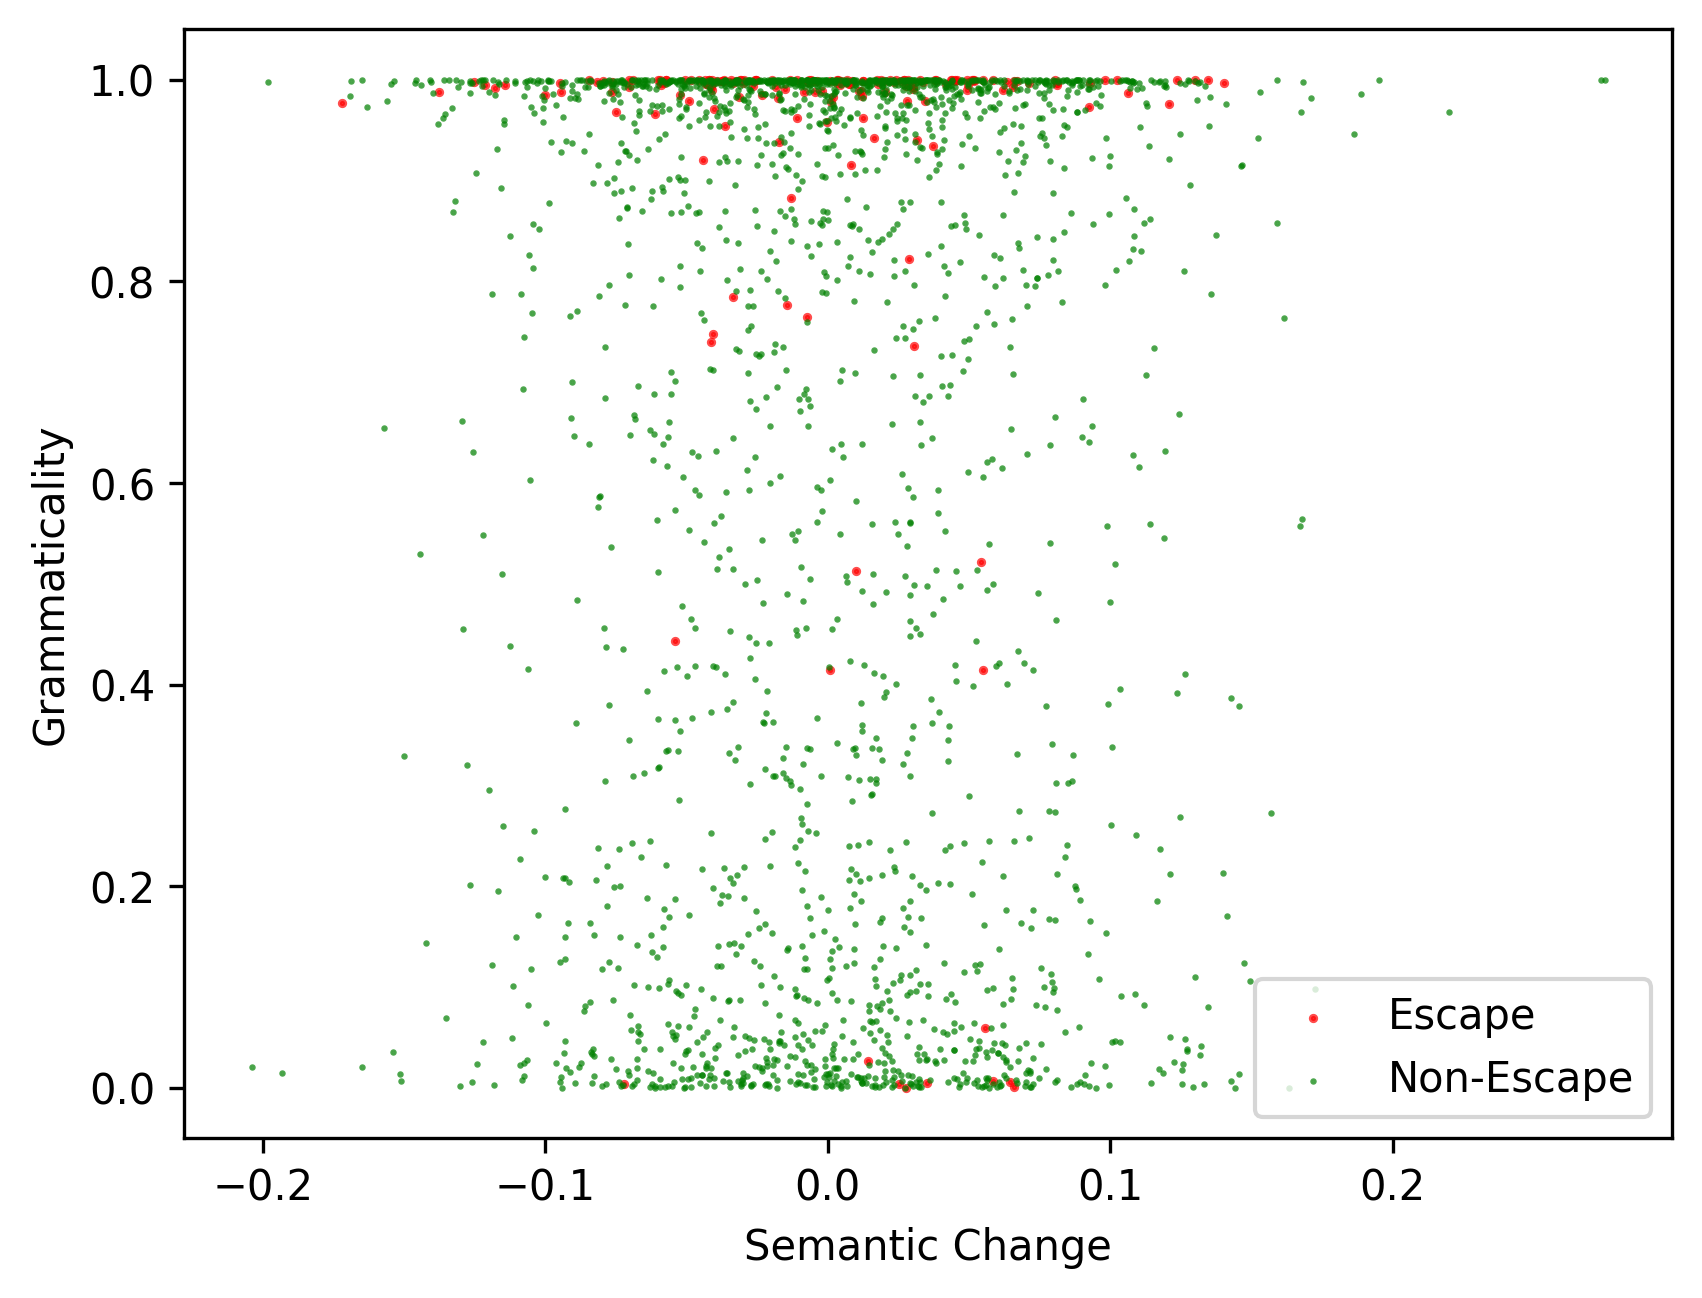

Plot Saved sucessfully to path: ../data/resultsx/fitness_visualization/baum_viz.png


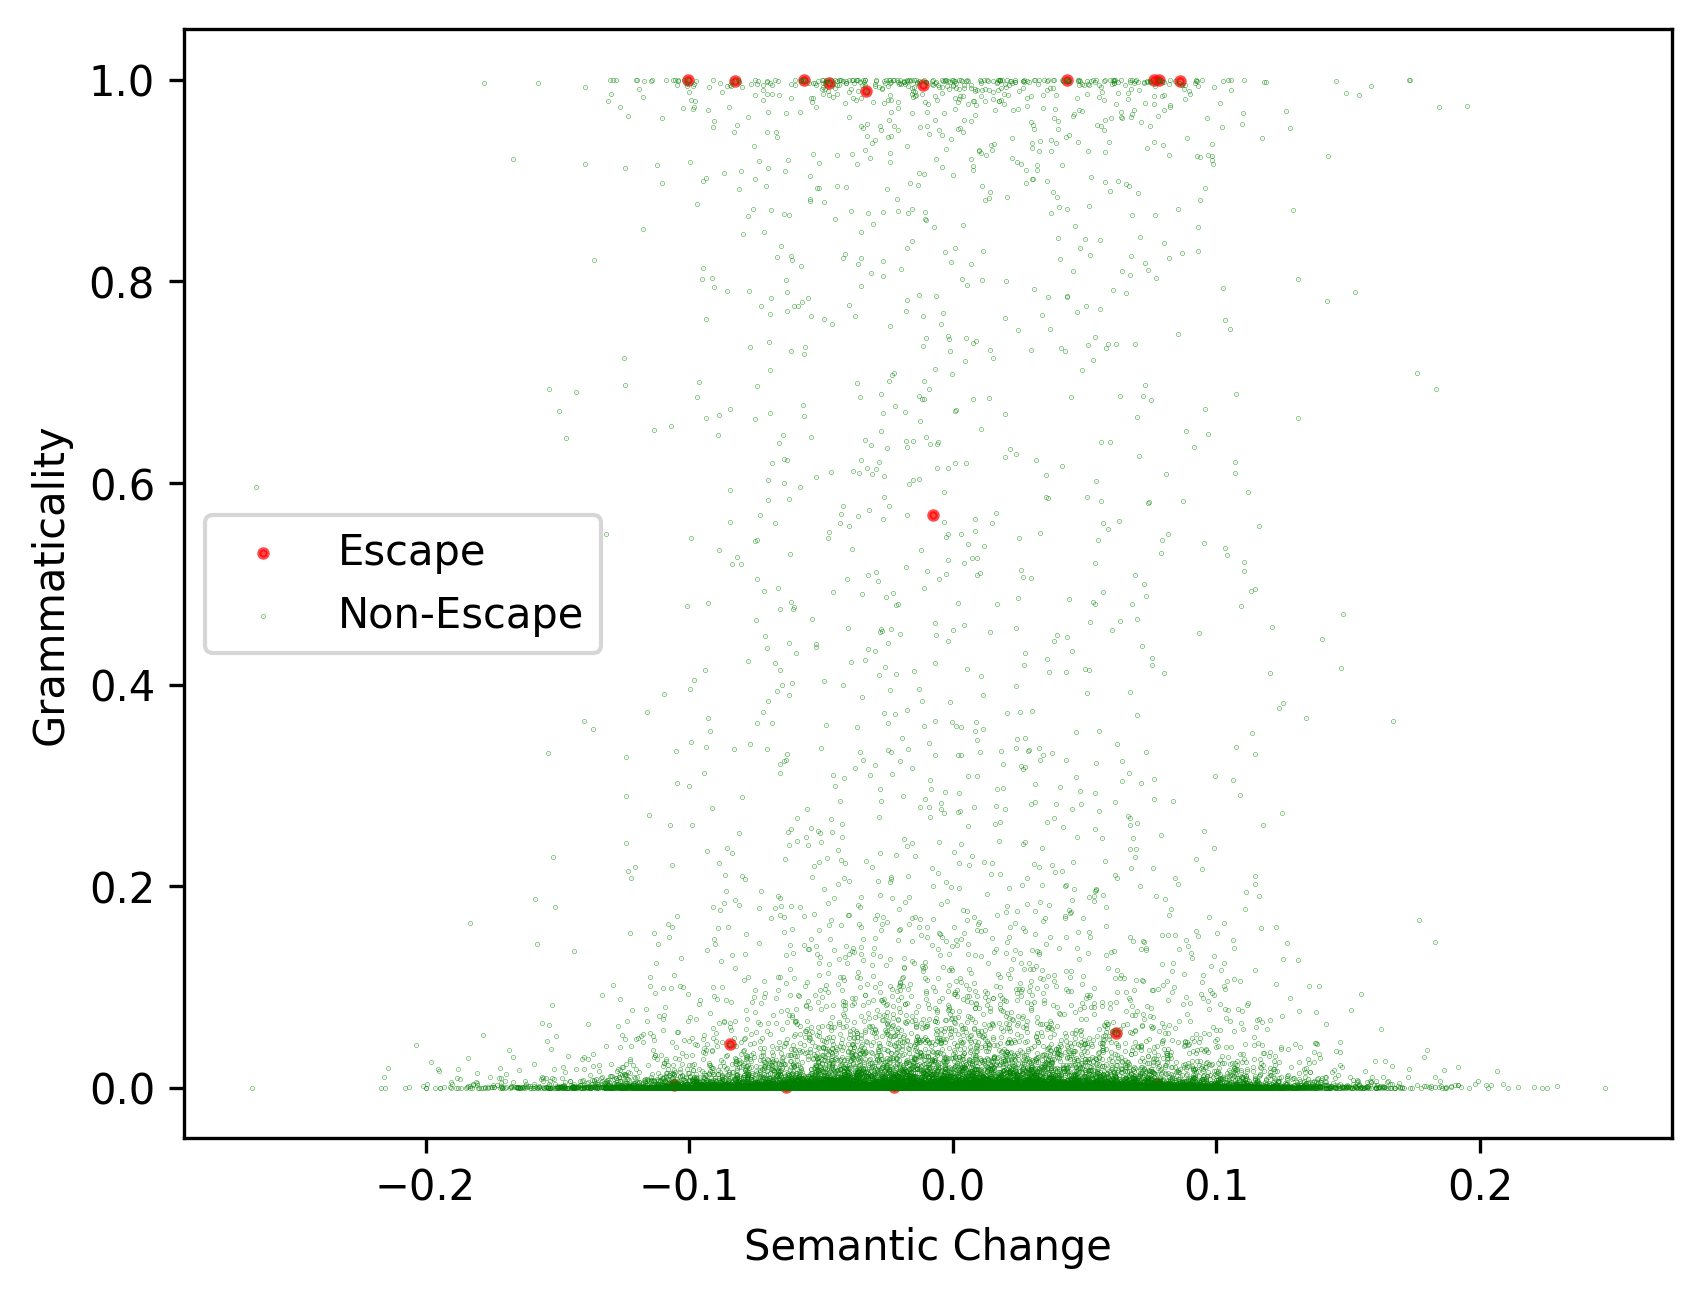

In [414]:
'''
fitness_gramm_path='/home/perm/sars_escape_netv2/data/raw/greaney_fitness_sig_gramm_data.csv'
# generate_fitness_data(fitness_gen_path)
predict_gram_fitness_results(bind_gen_path)

#Grammaticality and fiteness records
sig_fitness_gramm_path1 = '/home/perm/sars_escape_netv2/data/raw/greaney_fitness_sig_gramm_data.csv'
nonsig_fitness_gramm_path2 = '/home/perm/sars_escape_netv2/data/raw/greaney_fitness_nonsig_gramm_data.csv'

escap_fracs_sig, gramm_sg = load_escape_gramm(sig_fitness_gramm_path1)  #sig
escap_fracs_non_sig, gramm_nonsig = load_escape_gramm(nonsig_fitness_gramm_path2) #nonsig



bind_gen_path = "/home/perm/sars_escape_netv2/data/raw/bind_window_seqs_gen.csv"
bind_output_path = "/home/perm/sars_escape_netv2/data/raw/bind_window_seqs_gen_output.csv"
non_sig_wild, non_sig_mut = get_windows(com_nonsig_path)
sig_semantic_change = sig_embed_mut_score - sig_embed_wild_score
bind_output_with_wild_path ="/home/perm/sars_escape_netv2/data/raw/bind_window_seqs_gen_output_with_wild.csv"
bind_gramm_sem_save_path = '/home/perm/sars_escape_netv2/data/raw/fiteness_gram_sem_scores.csv'
generated_bind_output_along_wild_seq(bind_output_path , bind_output_with_wild_path)
generate_bind_gramm_sem_score(bind_output_with_wild_path, bind_gramm_sem_save_path)
binding_cut_off_generator(bind_gen_path)
predict_binding_score(bind_gen_path, bind_output_path)
bind, expr, gramm, sem = load_binding_gramm(bind_gramm_sem_save_path)
'''
compute_and_plot_fitness()
